In [4]:
import pandas as pd

df_train = pd.read_csv("https://raw.githubusercontent.com/redsonlopez/machine_learning/main/housing_prices_train.csv", index_col='Id')
df_test = pd.read_csv("https://raw.githubusercontent.com/redsonlopez/machine_learning/main/housing_prices_test.csv", index_col='Id')

X = df_train.copy()
y = X.pop("SalePrice")

X.select_dtypes(["object"]).nunique() # How many categories each categorical feature has

MSZoning          5
Street            2
Alley             2
LotShape          4
LandContour       4
Utilities         2
LotConfig         5
LandSlope         3
Neighborhood     25
Condition1        9
Condition2        8
BldgType          5
HouseStyle        8
RoofStyle         6
RoofMatl          8
Exterior1st      15
Exterior2nd      16
MasVnrType        4
ExterQual         4
ExterCond         5
Foundation        6
BsmtQual          4
BsmtCond          4
BsmtExposure      4
BsmtFinType1      6
BsmtFinType2      6
Heating           6
HeatingQC         5
CentralAir        2
Electrical        5
KitchenQual       4
Functional        7
FireplaceQu       5
GarageType        6
GarageFinish      3
GarageQual        5
GarageCond        5
PavedDrive        3
PoolQC            3
Fence             4
MiscFeature       4
SaleType          9
SaleCondition     6
dtype: int64

In [6]:
X["SaleType"].value_counts()

WD       1267
New       122
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [ ]:
# Store the column names
original_column_names = X.columns

# Label encoding for categoricals
for colname in X.select_dtypes(["category", "object"]):
    X[colname], _ = X[colname].factorize()

from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=1)
X = pd.DataFrame(imputer.fit_transform(X), columns= original_column_names)

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int

In [ ]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

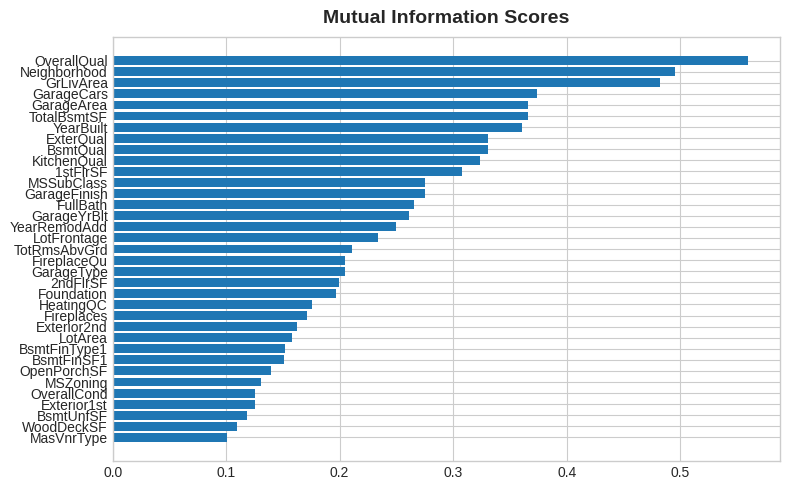

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[mi_scores > 0.1])

In [ ]:
features = mi_scores[mi_scores > 0.05].index
X = X[features]

from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

def score_dataset(X, y, model=XGBRegressor()):
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

score_dataset(X, y)

0.13938264534553532